<a href="https://colab.research.google.com/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-CIFAR_10/Identification_Objets-ResConv-CIFAR_10.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rappel - Fonctionnement d'un carnet web iPython

* Pour exécuter le code contenu dans une cellule d'un carnet iPython, cliquez dans la cellule et faites (⇧↵, shift-enter) 
* Le code d'un carnet iPython s'exécute séquentiellement de haut en bas de la page. Souvent, l'importation d'une bibliothèque Python ou l'initialisation d'une variable est préalable à l'exécution d'une cellule située plus bas. Il est donc recommandé d'exécuter les cellules en séquence. Enfin, méfiez-vous des retours en arrière qui peuvent réinitialiser certaines variables.

# Identification d'objets à partir de photos - jeu de données CIFAR-10
## Labo réseau convolutif - architecture de base

Inspiration: TensorFlow Tutorial <a href="https://www.tensorflow.org/tutorials/images/cnn?hl=fr" target='_blank'>Tutoriel TensorFlow - Réseau neuronal convolutif</a>



## Importation bibliothèques Python



In [1]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
print("TensorFlow version:",tf.__version__)
import keras
print("Keras version:",keras.__version__)

TensorFlow version: 2.9.2
Keras version: 2.9.0


## Fixer le hasard pour la reproductibilité

La mise au point de réseaux de neurones implique certains processus aléatoires. Afin de pouvoir reproduire et comparer vos résultats d'expérience, vous fixez temporairement l'état aléatoire grâce à un germe aléatoire unique.

Pendant la mise au point, vous fixez temporairement l'état aléatoire pour la reproductibilité mais vous répétez l'expérience avec différents germes ou états aléatoires et prenez la moyenne des résultats.
<br/>
##### **Note**: Pour un système en production, vous ravivez simplement l'état  purement aléatoire avec l'instruction `GERME_ALEATOIRE = None`

In [2]:
import os

# Définir un germe aléatoire
GERME_ALEATOIRE = 21

# Définir un état aléatoire pour Python
os.environ['PYTHONHASHSEED'] = str(GERME_ALEATOIRE)

# Définir un état aléatoire pour Python random
import random
random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour NumPy
import numpy as np
np.random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour TensorFlow
import tensorflow as tf
tf.random.set_seed(GERME_ALEATOIRE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

print("Germe aléatoire fixé")

Germe aléatoire fixé


## Jeu de données - photos CIFAR-10
L'ensemble de données CIFAR-10 (Canadian Institute For Advanced Research) comporte 60 000 photographies en couleur de 32×32 pixels d'objets de 10 classes différentes. Il est relativement simple d'atteindre une précision de 80 %. On peut obtenir des performances de 90 % avec ces données avec des réseaux neuronaux convolutifs. 

* 0 : avion
* 1 : automobile
* 2 : oiseau
* 3 : chat
* 4 : chevreuil
* 5 : chien
* 6 : grenouille
* 7 : cheval
* 8 : bateau
* 9 : camion

170498071/170498071 [==============================] - 3s 0us/step

Entraînement: attributs=(50000, 32, 32, 3), classes-cibles=(50000, 1)
Test: attributs=(10000, 32, 32, 3), classes-cibles=(10000, 1)

Quelques images avec leur étiquette de classe-cible...


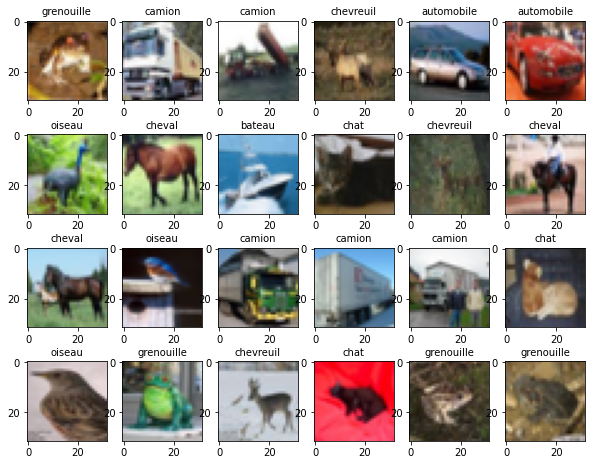

In [3]:
# Importer le jeu de données CIFAR-10
from keras.datasets import cifar10

dic_noms_classe = { 
    0 : "avion",
    1 : "automobile",
    2 : "oiseau",
    3 : "chat",
    4 : "chevreuil",
    5 : "chien",
    6 : "grenouille",
    7 : "cheval",
    8 : "bateau",
    9 : "camion",
}

# Lire le jeu de données CIFAR-10 et le diviser entre
# les données d'entrainement et les données de test
(attributs_entrainement, classes_cibles_entrainement), (attributs_test, classes_cibles_test) = cifar10.load_data()

# résumé des données 
print()
print('Entraînement: attributs=%s, classes-cibles=%s' % (attributs_entrainement.shape, classes_cibles_entrainement.shape))
print('Test: attributs=%s, classes-cibles=%s' % (attributs_test.shape, classes_cibles_test.shape))

# Afficher les 24 premières images
print()
print("Quelques images avec leur étiquette de classe-cible...")
%matplotlib inline
# définir lagrill d'affichage des images
fig, axes = plt.subplots(nrows=4,ncols=6,figsize=(10,8))
for i_rangee in range(0,4):
    for i_colonne in range(0,6):
        axes[i_rangee,i_colonne].set_title(dic_noms_classe[int(classes_cibles_entrainement[i_rangee*6+i_colonne])],
                                           fontsize=10)
        axes[i_rangee,i_colonne].imshow(attributs_entrainement[i_rangee*6+i_colonne])
plt.show()

## Prétraitement des données

In [4]:
from tensorflow.keras.utils import to_categorical

# Conversion des étiquettes de classes (ou classes-cibles) en attributs catégoriels,
# c'est-à-dire en vecteurs binaires à un bit discriminant
classes_cibles_entrainement = to_categorical(classes_cibles_entrainement)
classes_cibles_test = to_categorical(classes_cibles_test)

# Normalisation
def normalisation(entrainement, test):
    # convertir de nombres entiers à nombres décimaux
    entrainement_normalise = entrainement.astype('float32')
    test_normalise = test.astype('float32')
    # normalisation à un nombre entre 0 et 1
    entrainement_normalise = entrainement_normalise / 255.0
    test_normalise = test_normalise / 255.0
    return entrainement_normalise, test_normalise

attributs_entrainement, attributs_test = normalisation(attributs_entrainement, attributs_test)

print("Normalisation terminée!")

Normalisation terminée!


## Modèle de base - réseau convolutif

In [5]:
## Construction du modèle

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

print("Création d'un modèle de base...")
# vecteur / tenseur d'entrée: 
#   32 pixels de hauteur,
#   32 pixels de largeur,
#   3 canaux ou couleurs
dimensions_entree = (32, 32, 3)

# nombre de classes
nombre_classes_cibles = 10

modele_de_base = Sequential()

# Apprentissage et extraction des attributs
# couche convolutive
#   32 filtres de 3 par 3 pixels (kernel_size)
#      3 pixels de hauteur
#      3 pixels de largeur
#   bordure (padding) de 1 pixel, 'same'
#   fonction d'activation ReLU 
#   incrément de balayage (strides)
#      horizontal = 1
#      vertical = 1
modele_de_base.add(Conv2D(32, 
                          kernel_size=(3,3),
                          activation='relu',
                          kernel_initializer='glorot_uniform',
                          padding='same',
                          strides=(1,1),
                          input_shape=dimensions_entree))
# couche de sous-échantillonnage (pooling)
#   fenêtre d'échantillonnage de 2 par 2 pixels
modele_de_base.add(MaxPooling2D(pool_size=(2,2)))

# Classification des représentations par un perceptron multicouche
# aplatissement des représentations en un vecteur unique
modele_de_base.add(Flatten())
# Couche cachée intégralement connectée
#   128 neurones
modele_de_base.add(Dense(128,
                         activation='relu'))
# Couche de sortie intégralement connectée
#    nombre de neurones de sortie = nombre_classes_cibles
#    fonction d'activation de sortie = softmax (exponentielle normalisée)
modele_de_base.add(Dense(nombre_classes_cibles, 
                         activation='softmax'))

print()
print("Description du modèle de base:")
modele_de_base.summary()

Création d'un modèle de base...

Description du modèle de base:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 1,050,890
Trainable params: 1,050,890
Non-tr

In [6]:
modele_de_base.count_params()

1050890

In [7]:
# Compilation du modèle
#   comme il s'agit d'une classification multiclasses avec des attributs catégoriels
#   vous allez utiliser categorical_crossentropy
modele_de_base.compile(loss="categorical_crossentropy", 
                       optimizer="adam", 
                       metrics=["accuracy"])

print("Modèle de base compilé")

Modèle de base compilé


## Entraînement du modèle

In [8]:
# Entraînement du modèle
print("Entraînement du modèle de base...")

taille_lot = 128
epoques = 15

traces_entrainement = modele_de_base.fit(attributs_entrainement,
                                         classes_cibles_entrainement,
                                         batch_size=taille_lot,
                                         epochs=epoques,
                                         validation_split=0.1)

Entraînement du modèle de base...
Epoch 1/15
352/352 [==============================] - 43s 120ms/step - loss: 1.5369 - accuracy: 0.4570 - val_loss: 1.2964 - val_accuracy: 0.5518
Epoch 2/15
352/352 [==============================] - 42s 120ms/step - loss: 1.2267 - accuracy: 0.5696 - val_loss: 1.1631 - val_accuracy: 0.6066
Epoch 3/15
352/352 [==============================] - 40s 114ms/step - loss: 1.1131 - accuracy: 0.6104 - val_loss: 1.1153 - val_accuracy: 0.6172
Epoch 4/15
352/352 [==============================] - 42s 120ms/step - loss: 1.0294 - accuracy: 0.6423 - val_loss: 1.0978 - val_accuracy: 0.6164
Epoch 5/15
352/352 [==============================] - 42s 119ms/step - loss: 0.9706 - accuracy: 0.6614 - val_loss: 1.0621 - val_accuracy: 0.6302
Epoch 6/15
352/352 [==============================] - 41s 118ms/step - loss: 0.9099 - accuracy: 0.6840 - val_loss: 1.0281 - val_accuracy: 0.6446
Epoch 7/15
352/352 [==============================] - 40s 114ms/step - loss: 0.8611 - accuracy: 

## Évaluation du modèle

In [9]:
# Évaluation du modèle
# environ 63 %
print()
print("Évaluation du modèle de base...")

resultats = modele_de_base.evaluate(attributs_test, classes_cibles_test, verbose=0)
print("Exactitude test: {:.2f}%".format(resultats[1]*100))


Évaluation du modèle de base...
Exactitude test: 65.09%


## Affichage des courbes d'entraînement


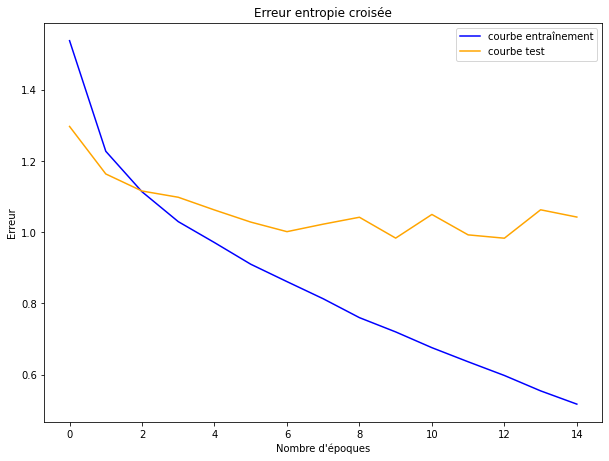

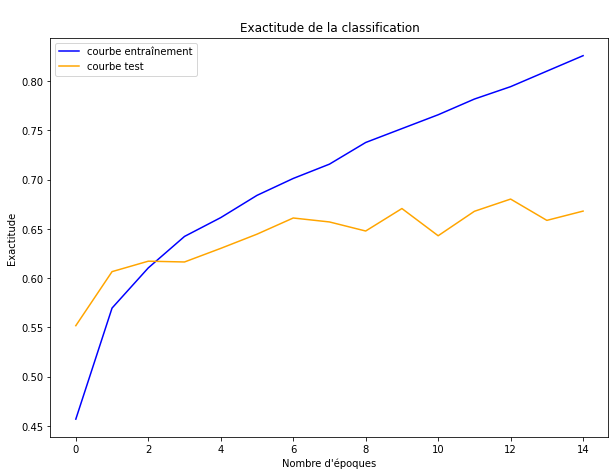

In [10]:
# Affichage des courbes d'entraînement
hauteur = 10
plt.subplots(figsize=(hauteur,1.618*hauteur))
plt.subplot(211)
plt.title('Erreur entropie croisée')
plt.plot(traces_entrainement.history['loss'], color='blue', label='courbe entraînement')
plt.plot(traces_entrainement.history['val_loss'], color='orange', label='courbe test')
plt.ylabel("Erreur")
plt.xlabel("Nombre d'époques")
plt.legend()
plt.show()
# tracer l'exactitude
plt.subplots(figsize=(hauteur,1.618*hauteur))
plt.subplot(212)
plt.title('\nExactitude de la classification')
plt.plot(traces_entrainement.history['accuracy'], color='blue', label='courbe entraînement')
plt.plot(traces_entrainement.history['val_accuracy'], color='orange', label='courbe test')
plt.ylabel("Exactitude")
plt.xlabel("Nombre d'époques")
plt.legend()
plt.show()
# Sauvegarde du graphique en format .png
# nom_graphique = "modele_de_base-courbes_entraînement.png"
# plt.savefig(nom_graphique)
# plt.close()

In [ ]:
print("Carnet IPython exécution terminée!")